# Implicit Diffusion via Relaxation

We want to solve the implicit heat equation via relaxation.  Our discretized form of the equation is:

$$-\alpha \phi^{n+1}_{i-1} + (1 + 2\alpha) \phi_i^{n+1}
- \alpha \phi_{i+1}^{n+1} = \phi_i^n$$

We'll write the righthand side as $f_i$, with 

$$f_i = \phi_i^n$$

then, solving for $\phi_i^{n+1}$, our relaxation update is:

$$\phi_{i}^{n+1} = (1 + 2\alpha)^{-1} \left (f_i + \alpha \phi_{i+1}^{n+1} + \alpha \phi_{i-1}^{n+1} \right )$$

We can use the same class we did for the Poisson equation, but with a modified relaxation and residual routine as well as a time loop encompassing the entire update.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
class Grid:
    """an implementation of solving the Poisson equation via pure relaxation"""

    def __init__(self, nx, ng=1, xmin=0, xmax=1):

        self.xmin = xmin
        self.xmax = xmax
        self.ng = ng
        self.nx = nx
        
        # python is zero-based.  Make easy integers to know where the
        # real data lives
        self.ilo = ng
        self.ihi = ng+nx-1

        # physical coords -- cell-centered
        self.dx = (xmax - xmin)/(nx)
        self.x = xmin + (np.arange(nx+2*ng)-ng+0.5)*self.dx

        # storage for the solution
        self.phi = self.scratch_array()
        self.f = self.scratch_array()

    def scratch_array(self):
        """return a scratch array dimensioned for our grid """
        return np.zeros((self.nx+2*self.ng), dtype=np.float64)

    def norm(self, e):
        """compute the L2 norm of e that lives on our grid"""
        return np.sqrt(self.dx * np.sum(e[self.ilo:self.ihi+1]**2))


    def fill_bcs(self):
        """fill the boundary conditions on phi"""

        # we only deal with a single ghost cell here and Neumann BCs
        self.phi[self.ilo-1] = self.phi[self.ilo]
        self.phi[self.ihi+1] = self.phi[self.ihi]

Here's the class that just holds the residual and relaxation routine.  We only needed
to change the coefficients of the $\phi$ terms to implement this new equation.

In [3]:
class ParabolicSolve:
    
    def __init__(self, grid, alpha):
        self.grid = grid
        self.alpha = alpha
        
    def residual_norm(self):
        """compute the residual norm"""
        g = self.grid
        r = g.scratch_array()
        r[g.ilo:g.ihi+1] = g.f[g.ilo:g.ihi+1] - \
            (-self.alpha * (g.phi[g.ilo+1:g.ihi+2] + g.phi[g.ilo-1:g.ihi]) +
             (1.0 + 2.0 * self.alpha) * g.phi[g.ilo:g.ihi+1])
        return g.norm(r)

    def relax(self, tol=1.e-8):

        g = self.grid
        fnorm = g.norm(g.f)

        g.fill_bcs()
        r = self.residual_norm()

        while r > tol * fnorm:

            g.phi[g.ilo:g.ihi+1:2] = 1.0 / (1.0 + 2.0 * self.alpha) * (
                g.f[g.ilo:g.ihi+1:2] +
                self.alpha * (g.phi[g.ilo+1:g.ihi+2:2] +
                              g.phi[g.ilo-1:g.ihi:2]))

            g.fill_bcs()

            g.phi[g.ilo+1:g.ihi+1:2] = 1.0 / (1.0 + 2.0 * self.alpha) * (
                g.f[g.ilo+1:g.ihi+1:2] +
                self.alpha * (g.phi[g.ilo+2:g.ihi+2:2] +
                              g.phi[g.ilo:g.ihi:2]))

            g.fill_bcs()

            r = self.residual_norm()

We'll use the same BCs as before

In [4]:
def gaussian_ic(g, k, t=0.0, t0=1.e-4, phi1=1.0, phi2=2.0):
    xc = 0.5*(g.xmin + g.xmax)
    return (phi2 - phi1) * (np.sqrt(t0/(t + t0)) *
                            np.exp(-0.25 * (g.x - xc)**2 / (k * (t + t0)))) + phi1

Our driver is again essentially the same as we used for the direct solve,
except now we setup the `ParabolicSolve` and solve it each timestep.

In [5]:
def diffuse_implicit(nx, k, C, tmax, init_cond):
    """
    the main evolution loop.  Evolve

     phi_t = k phi_{xx}

    from t = 0 to tmax
    """

    # create the grid
    ng = 1
    
    g = Grid(nx, ng)

    # time info
    dt = C * 0.5 *g.dx**2 / k
    t = 0.0

    # initialize the data
    g.phi[:] = init_cond(g, k)

    while t < tmax:

        # make sure we end right at tmax
        if t + dt > tmax:
            dt = tmax - t

        # diffuse for dt
        
        alpha = k * dt / g.dx**2
        
        solver = ParabolicSolve(g, alpha)
        g.f[:] = g.phi[:]
        solver.relax()
        t += dt

    return g

We'll solve with the same conditions as used for the direct solve.  Aside from roundoff / relaxation tolerance error, the
two methods are identical.  They are just going about solving the linear system differently.

In [6]:
nx = 128

k = 1

t_diffuse = (1.0/nx)**2 / k

In [7]:
tmax = 10 * t_diffuse


In [8]:
C = 10
g = diffuse_implicit(nx, k, C, tmax, gaussian_ic)

(0.35, 0.65)

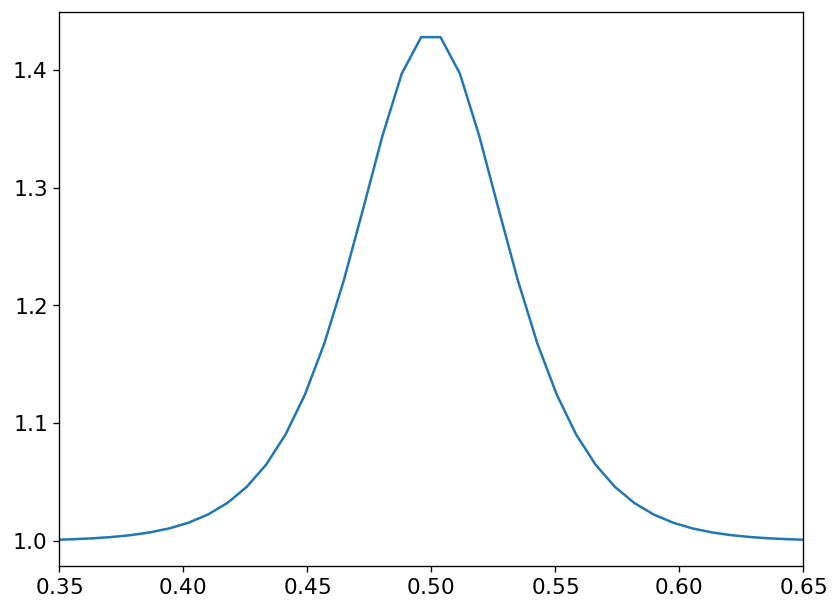

In [9]:
fig, ax = plt.subplots()
ax.plot(g.x[g.ilo:g.ihi+1], g.phi[g.ilo:g.ihi+1])

ax.set_xlim(0.35, 0.65)